<a href="https://colab.research.google.com/github/jadhav-rakesh/Cats_and_Dogs_Classifier/blob/main/cats_vs_dogs_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import tf_keras

CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf_keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))])

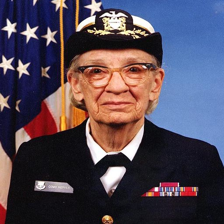

In [3]:
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [4]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [5]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 2s 2s/step


(1, 1001)

In [6]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

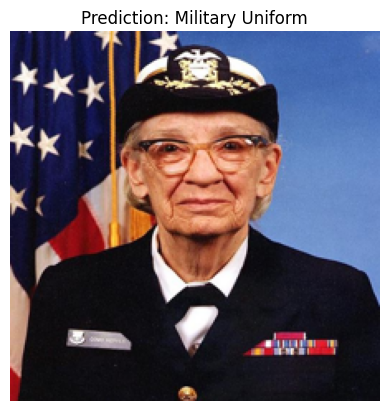

In [7]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis("off")
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: "+ predicted_class_name.title())

In [8]:
(train_examples, validation_examples), info = tfds.load(
    "cats_vs_dogs",
    with_info=True,
    as_supervised=True,
    split=["train[:80%]", "train[80%:]"]
)

num_examples = info.splits["train"].num_examples
num_classes = info.features["label"].num_classes

In [9]:
for i, example_image in enumerate(train_examples.take(3)):
    print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [10]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [11]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 1s 1s/step


array(['Tibetan mastiff', 'Australian terrier', 'Yorkshire terrier',
       'Great Dane', 'tabby', 'tabby', 'bucket', 'Siamese cat',
       'miniature schnauzer', 'Walker hound', 'tabby', 'tabby',
       'miniature pinscher', 'Chihuahua',
       'American Staffordshire terrier', 'Egyptian cat', 'Walker hound',
       'tabby', 'toy poodle', 'Great Dane', 'Labrador retriever',
       'flat-coated retriever', 'Persian cat', 'Chihuahua', 'schipperke',
       'Egyptian cat', 'Persian cat', 'Rottweiler', 'Christmas stocking',
       'Pomeranian', 'space heater', 'German shepherd'], dtype='<U30')

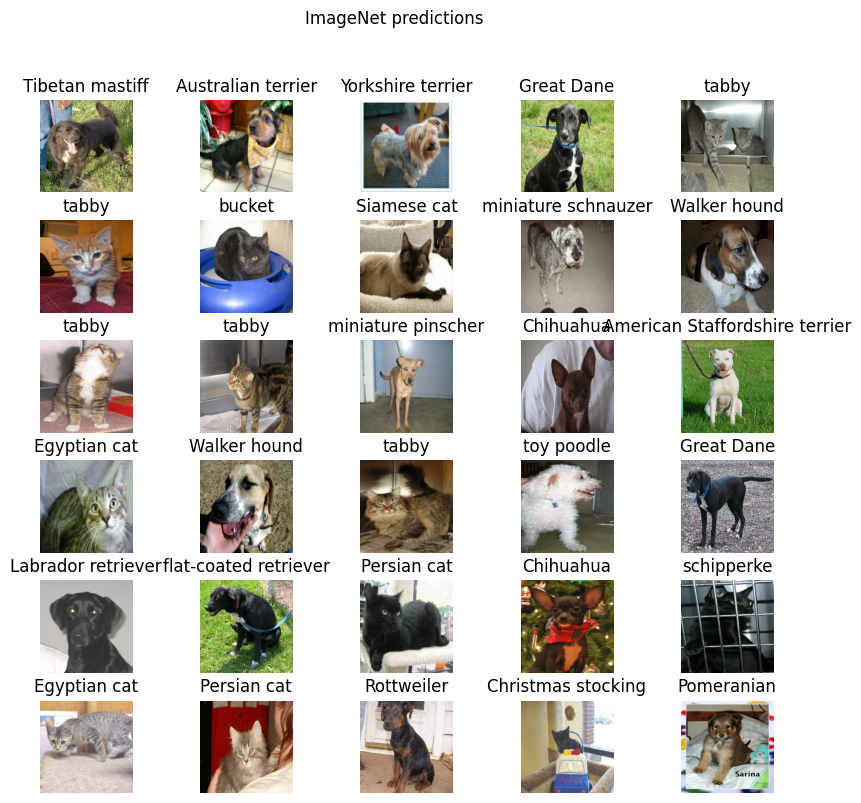

In [12]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6, 5, n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis("off")

_ = plt.suptitle("ImageNet predictions")

In [13]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3), trainable=False)

In [14]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [15]:
model = tf_keras.Sequential()
model.add(feature_extractor)
model.add(layers.Dense(2))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 module_wrapper (ModuleWrap  (None, 2)                 2562      
 per)                                                            
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [16]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

EPOCHS = 2

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/2
582/582 [==============================] - 867s 1s/step - loss: 0.0569 - accuracy: 0.9801 - val_loss: 0.0308 - val_accuracy: 0.9899
Epoch 2/2
582/582 [==============================] - 863s 1s/step - loss: 0.0308 - accuracy: 0.9889 - val_loss: 0.0295 - val_accuracy: 0.9903


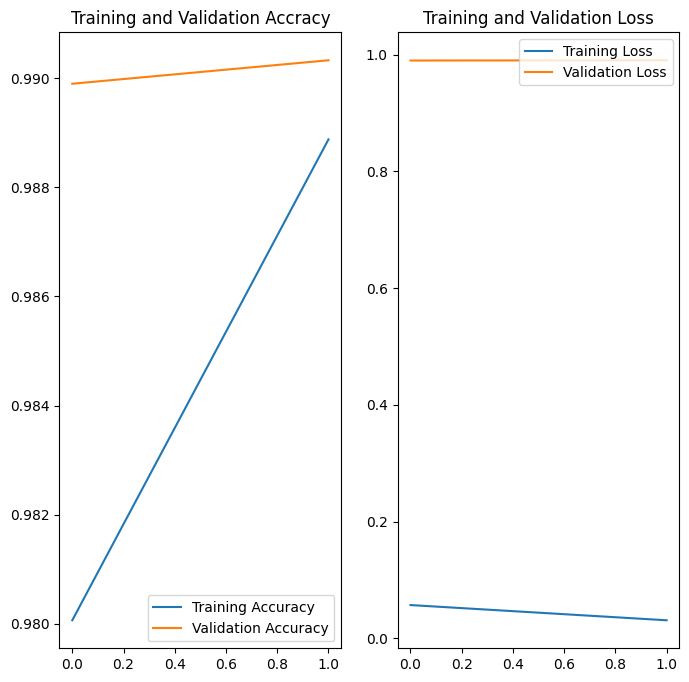

In [21]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_acc, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [22]:
class_names = np.array(info.features["label"].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [23]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 2s 2s/step


array(['dog', 'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'dog',
       'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat',
       'dog', 'dog', 'dog', 'dog', 'cat', 'dog', 'cat', 'cat', 'cat',
       'dog', 'cat', 'dog', 'cat', 'dog'], dtype='<U3')

In [24]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1]
Predicted labels:  [1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1]


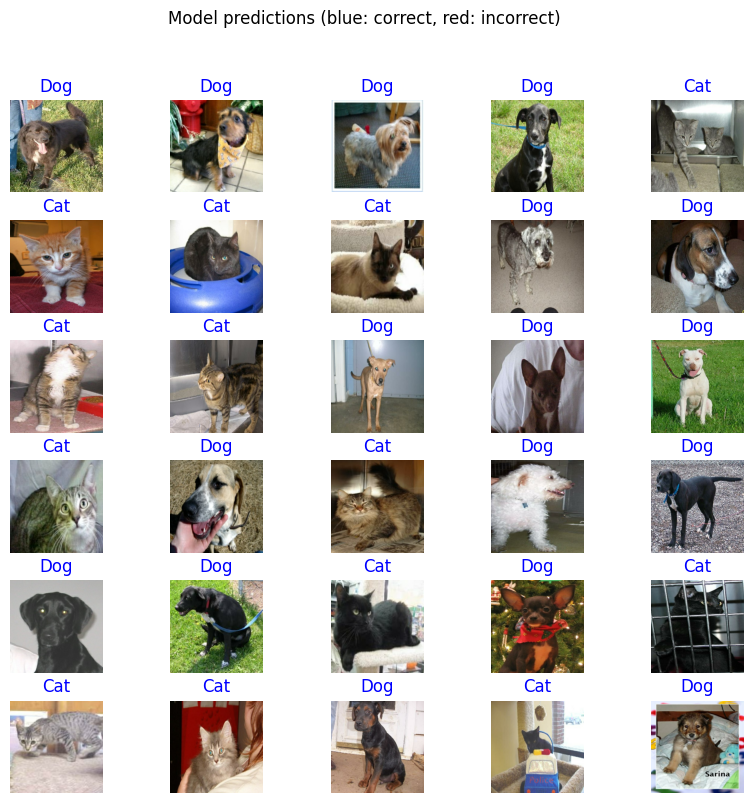

In [26]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis("off")
    _ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")